In [1]:
%matplotlib inline

# Qiskit standard libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, execute

# Qiskit specific tools
from qiskit.tools.visualization import plot_histogram
from qiskit.compiler import transpile

# Other imports
import numpy
import networkx

provider = IBMQ.load_account()
backends = provider.backends()
print(backends)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]


In [2]:
#### ========================= ####
#### QAOA Operations (1 round) ####
#### ========================= ####

# - circuit circ
# - problem graph G
# - mixing and phase separation angles beta, gamma
def initH(circ, G):
    for q in G.nodes():
        circ.h(q)

def measure(circ, G):
    for q in G.nodes():
        circ.measure(q, q)
    
def mixer(circ, G, beta):
    for q in G.nodes():
        circ.u3(2.0*beta, -numpy.pi/2.0, numpy.pi/2.0, q)

def phaseSep(circ, G, gamma):
    for q0, q1 in G.edges():
        # phase separator
        circ.cx(q1, q0)
        circ.u1(-gamma, q0)
        circ.cx(q1,q0)

def phaseSep_old(circ, G, gamma):
    for q0, q1 in G.edges():
        # unnecessary global phase on q1
        circ.x(q1)
        circ.u1(-gamma/2.0, q1)
        circ.x(q1)
        circ.u1(-gamma/2.0, q1)
        # phase separator
        circ.cx(q1, q0)
        circ.x(q0)
        circ.u1(gamma/2.0, q0)
        circ.x(q0)
        circ.u1(-gamma/2.0, q0)
        circ.cx(q1,q0)

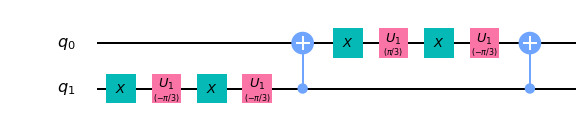

In [3]:
#### ================================================ ####
#### Comparison of Old and Simplified Phase Separator ####
#### ================================================ ####

# Single edge
G = networkx.Graph([(0,1)])

# Old Phase Separator Circuit
circPS_old = QuantumCircuit(2)
phaseSep_old(circPS_old, G, 2.0*numpy.pi/3.0)
circPS_old.draw()

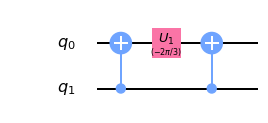

In [4]:
# Simplified Phase Separator Circuit
circPS = QuantumCircuit(2)
phaseSep(circPS, G, 2.0*numpy.pi/3.0)
circPS.draw()

In [5]:
# Simulating Circuit Unitaries
unitary_simulator = Aer.get_backend('unitary_simulator')

# Execute and get counts of Old Phase Separator
result = execute(circPS_old, unitary_simulator).result()
unitary = result.get_unitary(circPS_old)
print("Circuit unitary of Old Phase Separator:\n", unitary)

# Execute and get counts of Simplified Phase Separator
result = execute(circPS, unitary_simulator).result()
unitary = result.get_unitary(circPS)
print("\nCircuit unitary of Simplified Phase Separator:\n", unitary)

Circuit unitary of Old Phase Separator:
 [[ 1. +0.j         0. +0.j         0. +0.j         0. +0.j       ]
 [ 0. +0.j        -0.5-0.8660254j  0. +0.j         0. +0.j       ]
 [ 0. +0.j         0. +0.j        -0.5-0.8660254j  0. +0.j       ]
 [ 0. +0.j         0. +0.j         0. +0.j         1. +0.j       ]]

Circuit unitary of Simplified Phase Separator:
 [[ 1. +0.j         0. +0.j         0. +0.j         0. +0.j       ]
 [ 0. +0.j        -0.5-0.8660254j  0. +0.j         0. +0.j       ]
 [ 0. +0.j         0. +0.j        -0.5-0.8660254j  0. +0.j       ]
 [ 0. +0.j         0. +0.j         0. +0.j         1. +0.j       ]]


In [6]:
#### =============== ####
#### QAOA (p rounds) ####
#### =============== ####

# - circuit circ
# - problem graph G
# - mixing and phase separation angle vectors beta, gamma

def QAOA(circ, G, beta, gamma):
    p = len(gamma)
    initH(circ, G)
    for i in range(p):
        phaseSep(circ, G, gamma[i])
        mixer(circ, G, beta[i])
    measure(circ,G)

def QAOA_old(circ, G, beta, gamma):
    p = len(gamma)
    initH(circ, G)
    for i in range(p):
        # WRONG ORDER HERE!
        mixer(circ, G, beta[i])
        phaseSep(circ, G, gamma[i])
    measure(circ,G)

In [7]:
## =========================================== ##
## Demonstration of (in)correct implementation ##
## =========================================== ##

# Devices
qasm_simulator = Aer.get_backend('qasm_simulator')
ibmqx2 = provider.get_backend('ibmqx2')

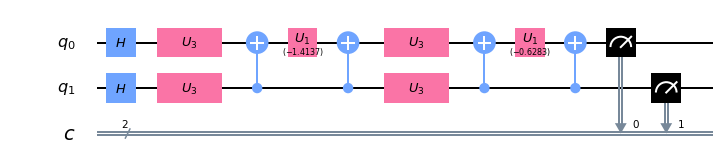

In [8]:
## Circuit of current (incorrect) implementation
circ_old = QuantumCircuit(2,2)
QAOA_old(circ_old, G, [0.0785, 0.3927], [1.4137, 0.6283])
# Simulate
result = execute(circ_old, qasm_simulator, shots=100000).result()
counts_old = result.get_counts(circ_old)
circ_old.draw()

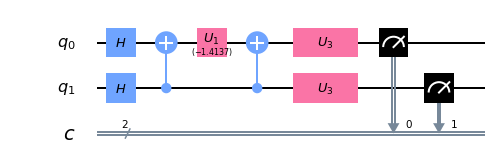

In [9]:
## Circuit of correct implementation
circ = QuantumCircuit(2,2)
QAOA(circ, G, [0.3927], [1.4137])
# Simulate
result = execute(circ, qasm_simulator, shots=100000).result()
counts = result.get_counts(circ)
circ.draw()

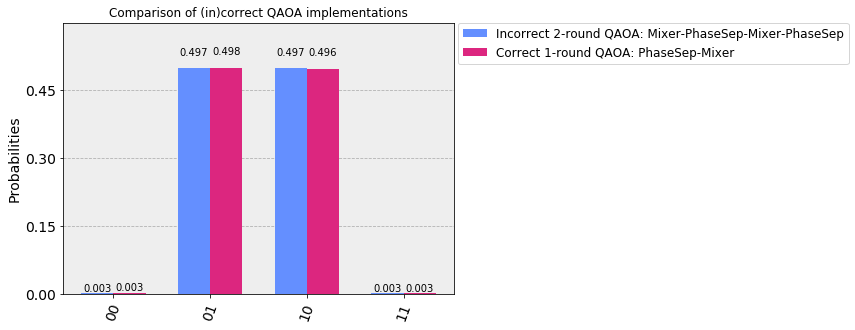

In [10]:
## Compare Results
plot_histogram(
    [counts_old,counts], 
    legend=['Incorrect 2-round QAOA: Mixer-PhaseSep-Mixer-PhaseSep','Correct 1-round QAOA: PhaseSep-Mixer'],
    title='Comparison of (in)correct QAOA implementations'
)

In [11]:
## ============================ ##
## Proof-of-Concept Experiments ##
#============================== ##

## Graphs
Edge = networkx.Graph([(1,2)])
Triangle = networkx.Graph([(2,3),(2,4),(3,4)])
TplusE = networkx.compose_all([Triangle,Edge])

Error checking job status using websocket, retrying using HTTP.


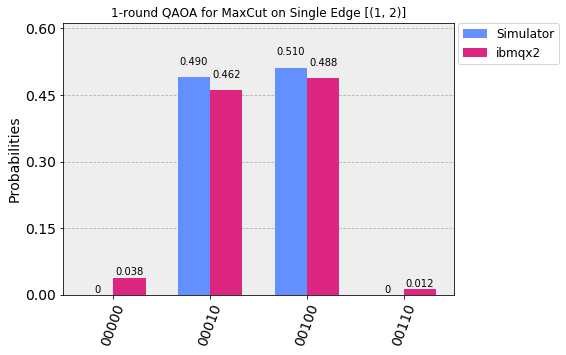

In [12]:
## Edge
## ====

circ_edge = QuantumCircuit(5,5)
QAOA(circ_edge, Edge, [numpy.pi*1.0/8.0], [numpy.pi/2.0])
# sim
result_edge_simulator = execute(circ_edge, qasm_simulator, shots=4096).result()
counts_edge_simulator = result_edge_simulator.get_counts(circ_edge)
# device
result_edge_ibmqx2 = execute(circ_edge, ibmqx2, shots=4096).result()
counts_edge_ibmqx2 = result_edge_ibmqx2.get_counts(circ_edge)
# results
plot_histogram(
    [counts_edge_simulator,counts_edge_ibmqx2], 
    legend=['Simulator','ibmqx2'],
    title='1-round QAOA for MaxCut on Single Edge {}'.format(Edge.edges())
)

Error checking job status using websocket, retrying using HTTP.


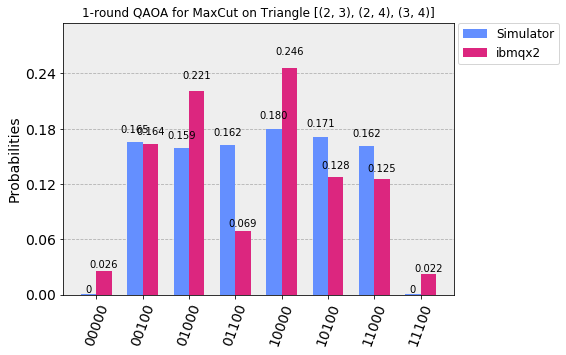

In [13]:
## Triangle
## ========

circ_triangle = QuantumCircuit(5,5)
QAOA(circ_triangle, Triangle, [numpy.pi*2.0/5.0], [numpy.pi*4.0/5.0])
# sim
result_triangle_simulator = execute(circ_triangle, qasm_simulator, shots=4096).result()
counts_triangle_simulator = result_triangle_simulator.get_counts(circ_triangle)
# device
result_triangle_ibmqx2 = execute(circ_triangle, ibmqx2, shots=4096).result()
counts_triangle_ibmqx2 = result_triangle_ibmqx2.get_counts(circ_triangle)
# results
plot_histogram(
    [counts_triangle_simulator,counts_triangle_ibmqx2], 
    legend=['Simulator','ibmqx2'],
    title='1-round QAOA for MaxCut on Triangle {}'.format(Triangle.edges())
)

Error checking job status using websocket, retrying using HTTP.


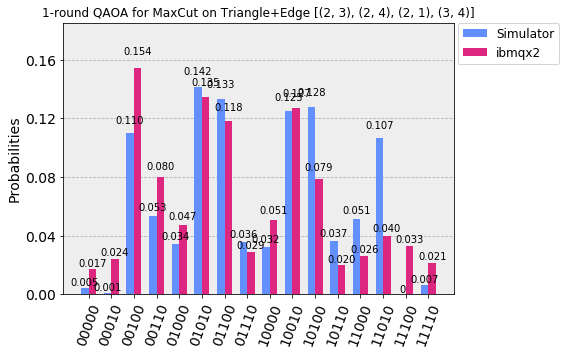

In [14]:
## Triangle plus Edge (1 round)
## ============================
''' params found by grid search with a resolution of 1/1000'''

circ_tpluse = QuantumCircuit(5,5)
QAOA(circ_tpluse, TplusE, [numpy.pi*21.0/200.0], [numpy.pi*26.0/125.0])
# sim
result_tpluse_simulator = execute(circ_tpluse, qasm_simulator, shots=4096).result()
counts_tpluse_simulator = result_tpluse_simulator.get_counts(circ_tpluse)
# device
result_tpluse_ibmqx2 = execute(circ_tpluse, ibmqx2, shots=4096).result()
counts_tpluse_ibmqx2 = result_tpluse_ibmqx2.get_counts(circ_tpluse)

# results
plot_histogram(
    [counts_tpluse_simulator,counts_tpluse_ibmqx2], 
    legend=['Simulator','ibmqx2'],
    title='1-round QAOA for MaxCut on Triangle+Edge {}'.format(TplusE.edges())
)

Error checking job status using websocket, retrying using HTTP.


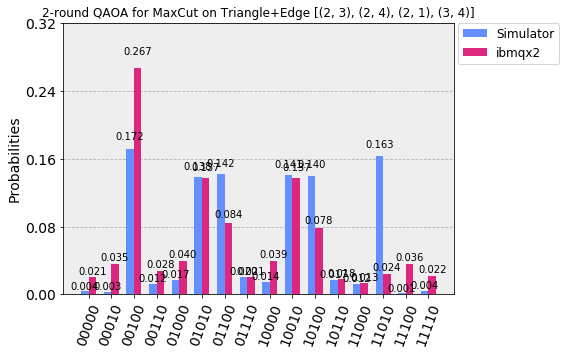

In [15]:
## Triangle plus Edge (2 rounds)
## =============================
''' params found by grid search with a resolution of 1/20'''

circ_tpluse2 = QuantumCircuit(5,5)
QAOA(circ_tpluse2, TplusE, [numpy.pi*3.0/20.0,numpy.pi*1.0/20.0], [numpy.pi*1.0/5.0,numpy.pi*2.0/5.0])
# sim
result_tpluse2_simulator = execute(circ_tpluse2, qasm_simulator, shots=4096).result()
counts_tpluse2_simulator = result_tpluse2_simulator.get_counts(circ_tpluse2)
# device
result_tpluse2_ibmqx2 = execute(circ_tpluse2, ibmqx2, shots=4096).result()
counts_tpluse2_ibmqx2 = result_tpluse2_ibmqx2.get_counts(circ_tpluse2)

# results
plot_histogram(
    [counts_tpluse2_simulator,counts_tpluse2_ibmqx2], 
    legend=['Simulator','ibmqx2'],
    title='2-round QAOA for MaxCut on Triangle+Edge {}'.format(TplusE.edges())
)

In [16]:
## Evaluation Functions
def cutsize(G, cut):
    # G:   networkx graph
    # cut: 5-digit binary string
    size = 0
    for u, v in G.edges():
        if cut[4-u] != cut[4-v]:
            size += 1
    return size

def resultstats(G, counts):
    # stats
    expectation = 0.0
    probability = 0.0
    # vals
    num_shots = sum(counts.values())
    maxcut = max([cutsize(G, format(cut, '05b')) for cut in range(2**5)])
    
    # compute stats
    for key, val in counts.items():
        expectation += val * cutsize(G,key)
        if cutsize(G, key) == maxcut:
            probability += val
            
    expectation /= num_shots
    probability /= num_shots
    
    return expectation, probability

In [17]:
## Printing Result Statistics
print("Results\n=======")

output = '''* "{}" has
  - Theoretical  Expectation {:.3f} and MaxCut Probability {:.3f}
  - Experimental Expectation {:.3f} and MaxCut Probability {:.3f}'''

print(output.format("Edge",
                    *resultstats(Edge, counts_edge_simulator),
                    *resultstats(Edge, counts_edge_ibmqx2)))
print(output.format("Triangle",
                    *resultstats(Triangle, counts_triangle_simulator),
                    *resultstats(Triangle, counts_triangle_ibmqx2)))
print(output.format("TplusE (1 round)",
                    *resultstats(TplusE, counts_tpluse_simulator),
                    *resultstats(TplusE, counts_tpluse_ibmqx2)))
print(output.format("TplusE (2 rounds)",
                    *resultstats(TplusE, counts_tpluse2_simulator),
                    *resultstats(TplusE, counts_tpluse2_ibmqx2)))

Results
* "Edge" has
  - Theoretical  Expectation 1.000 and MaxCut Probability 1.000
  - Experimental Expectation 0.950 and MaxCut Probability 0.950
* "Triangle" has
  - Theoretical  Expectation 1.999 and MaxCut Probability 1.000
  - Experimental Expectation 1.904 and MaxCut Probability 0.952
* "TplusE (1 round)" has
  - Theoretical  Expectation 2.720 and MaxCut Probability 0.744
  - Experimental Expectation 2.519 and MaxCut Probability 0.652
* "TplusE (2 rounds)" has
  - Theoretical  Expectation 2.874 and MaxCut Probability 0.895
  - Experimental Expectation 2.570 and MaxCut Probability 0.727


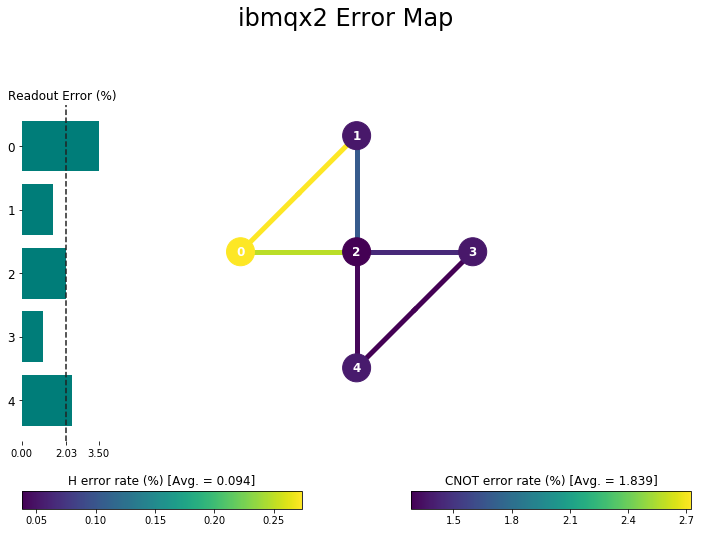

In [18]:
from qiskit.tools.visualization import plot_error_map
plot_error_map(ibmqx2)

In [1]:
circ_tpluse.draw()

NameError: name 'circ_tpluse' is not defined